TNE 1 Linear Regression for Ozone rate prediction
===

In [30]:
from pylab import *
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from copy import deepcopy

%matplotlib inline

# Exercice 1
## Reading data

In [31]:
data = pd.read_csv('ozone_data.txt', sep='\t')

## Data Analysis 

First, we'll try to visualize pairwise relationships in a our dataset by using PairPlot function from seaborn.


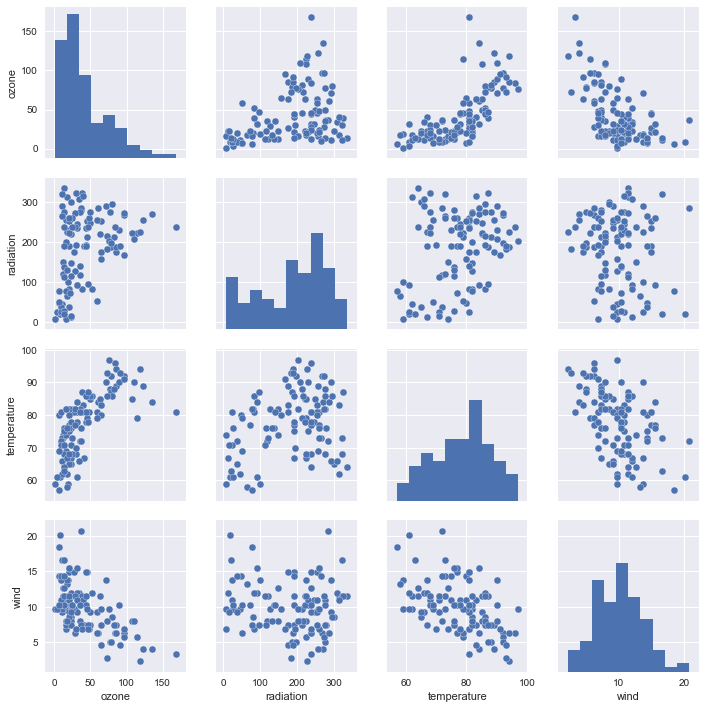

In [32]:
sns.pairplot(data)

From this visualization, we can see clearly that the pair (temperature, ozone) is the most correlated followed by the pair (wind, ozone).

Let's plot the covariance matrix :

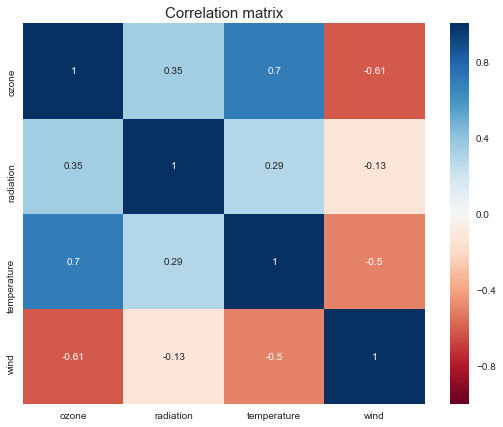

In [46]:
corr = data.corr()
plt.figure(figsize=(9,7))
plt.title('Correlation matrix', size=15)
sns.heatmap(corr, annot=True, cmap='RdBu')

The covariance matrix confirmed our observations:
* (temperature and ozone) is the most correlated pair : 0.7
* (wind and ozone) is the most inversely correlated pair : -0.61

## Linear Regression

For the linear regression, we decided to use scikitlearn package as we achived the implementation of Linear Regression algorithm before.
We will perform regression on standarized data (for iterpretation ease).

In [47]:
# Standarize data
N = len(data)

scaler = StandardScaler()
scaler.fit(data[:int(0.75*N)])

# Save a copy of data
data_N = deepcopy(data)

data_N[['ozone', 'radiation', 'temperature', 'wind']] = scaler.transform(data)

# Creating train and test sets
train   = data_N[['radiation', 'temperature', 'wind']][:int(0.75*N)] # 75% de la data
train_t = data_N['ozone'][:int(0.75*N)]
test    = data_N[['radiation', 'temperature', 'wind']][int(0.75*N):] # 25% de la data
test_t  = data_N['ozone'][int(0.75*N):]


In [48]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(train, train_t)

# Make predictions using the testing set
pred_t = regr.predict(test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.5f"
      % mean_squared_error(test_t, pred_t))


Coefficients: 
 [ 0.16342695  0.44130205 -0.39962476]
Mean squared error: 0.27035


**As we standarized the data, the MSE is about 27% of the variance. Our prediction is within a tolerable range around the mean, but still not accurate.**

## Feature engineering
We try to create new features from existing ones in order to have better quality entries.

In [49]:
rad, temp, win = data['radiation'], data['temperature'], data['wind']

# Create new fetures from existing ones (by brainstorming and testing)
rad_temp =  pd.DataFrame(data={'rad*temp': rad*temp})
temp_win =  pd.DataFrame(data={'temp*win': temp*win})
temp2    =  pd.DataFrame(data={'temp^2': temp**3})
win_rad  =  pd.DataFrame(data={'win*rad': (win*rad)})
win_rad3 =  pd.DataFrame(data={'(win*rad)^3': (win*rad)**3})

# Input vectors

I = ['radiation','temperature','wind'] # original input vector
I1  = ['radiation', 'temperature', 'wind', 'rad*temp', 'temp*win', 'temp^2', 'win*rad', '(win*rad)^3']
I2 = ['radiation', 'temperature', 'wind', 'rad*temp', 'temp*win', 'win*rad']
I3 = ['radiation', 'temperature', 'rad*temp', 'temp^2']
I4 = ['temperature','rad*temp','temp^2', '(win*rad)^3']


In [50]:
# New crafted data set
data2 = pd.concat([data, rad_temp, temp_win, temp2, win_rad, win_rad3], axis=1)

# Standarize
scaler = StandardScaler()
scaler.fit(data2[:int(0.75*N)])
data2[['ozone'] + I1] = scaler.transform(data2)

For each input, we'll predict a linear regression model and compare the corresponding mean square error.

<Container object of 5 artists>

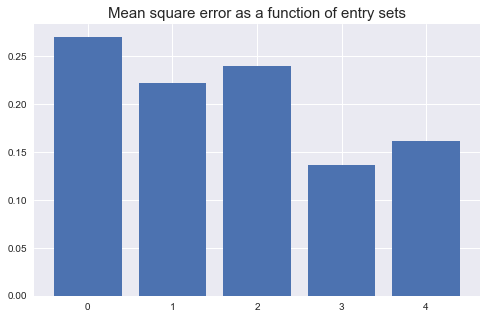

In [51]:
attrib = [I, I1, I2, I3, I4]
err = []
for i in attrib :
    # Split data set
    train2   = data2[i][: int(0.75*N)] 
    train2_t = data2['ozone'][:int(0.75*N)]
    test2    = data2[i][int(0.75*N):] 
    test2_t  = data2['ozone'][int(0.75*N):]
    
    # Create linear regression object
    regr2 = linear_model.LinearRegression()
    
    # Train the model using the training sets
    regr2.fit(train2, train2_t)
    
    # Make predictions using the testing set
    pred2_t = regr2.predict(test2)
    
    # MSE
    err+= [mean_squared_error(test2_t, pred2_t)]

plt.figure(figsize=(8,5))
plt.title('Mean square error as a function of entry sets', size=15)
plt.bar(range(5), err)

- All crafted features yield a better result than the original one (first column). Beginner chance ?
- The temperature multipliers and powers improved the results.
- The MSE has been improved by 50% (between I and I3).

## Ridge Regression
Using ridge regression, we'll try to improve the linear models found earlier.

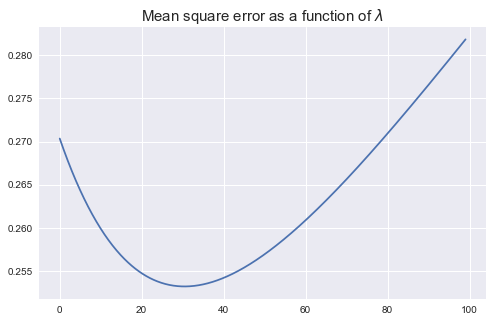

In [52]:
Lambda = np.linspace(0,99,1000)
err3 = []
for l in Lambda :
    
    # Create linear regression object
    regr3 = linear_model.Ridge(l)
    
    # Train the model using the training sets
    regr3.fit(train, train_t)
    
    # Make predictions using the testing set
    pred3_t = regr3.predict(test)
    
    err3 += [mean_squared_error(test_t, pred3_t)]

plt.figure(figsize=(8,5))
plt.title('Mean square error as a function of $\lambda$', size=15)
plt.plot(Lambda, err3)

In [53]:
Lambda_best = argmin(err3)/10
print(' The best lambda parameter in this case is lambda = ',Lambda_best,'\n The corresponding error is : ', min(err3))

 The best lambda parameter in this case is lambda =  30.7 
 The corresponding error is :  0.253235986778


The MSE was slightly improved, but its performance is still far below the one with modified features.
Let's try to combine both methods.

In [57]:
# After a first iteration we found that the best lambda is between 0 and 1 (except for original input)
Lambda2 = np.linspace(0,1,1000)
err4 = [min(err3)]

for i in attrib[1:] :
    train4   = data2[i][: int(0.75*N)] 
    train4_t = data2['ozone'][:int(0.75*N)]
    test4    = data2[i][int(0.75*N):] 
    test4_t  = data2['ozone'][int(0.75*N):]
    errors = []
    
    for l in Lambda2 :
        # Create linear regression object
        regr4 = linear_model.Ridge(l)
    
        # Train the model using the training sets
        regr4.fit(train4, train4_t)
    
        # Make predictions using the testing set
        pred4_t = regr4.predict(test4)
    
        errors += [mean_squared_error(test4_t, pred4_t)]
        
    Lambda_best = argmin(errors)/1000
    print('\n The best lambda parameter for features : ',i,' is lambda = ',Lambda_best,
          '\n The corresponding error is : ', min(errors))
    err4 +=[min(errors)]



 The best lambda parameter for features :  ['radiation', 'temperature', 'wind', 'rad*temp', 'temp*win', 'temp^2', 'win*rad', '(win*rad)^3']  is lambda =  0.771 
 The corresponding error is :  0.218905693812

 The best lambda parameter for features :  ['radiation', 'temperature', 'wind', 'rad*temp', 'temp*win', 'win*rad']  is lambda =  0.616 
 The corresponding error is :  0.226767838397

 The best lambda parameter for features :  ['radiation', 'temperature', 'rad*temp', 'temp^2']  is lambda =  0.0 
 The corresponding error is :  0.136288154988

 The best lambda parameter for features :  ['temperature', 'rad*temp', 'temp^2', '(win*rad)^3']  is lambda =  0.0 
 The corresponding error is :  0.161345446726


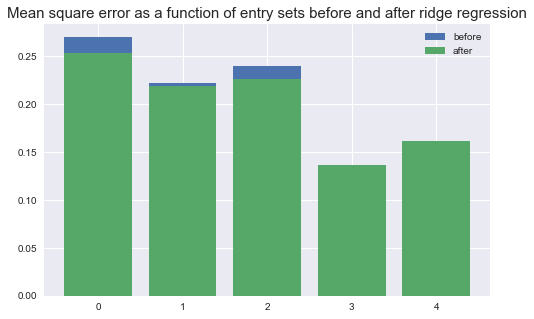

In [64]:
plt.figure(figsize=(8,5))
plt.title('Mean square error as a function of entry sets before and after ridge regression', size=15)
plt.bar(range(5), err)
plt.bar(range(5), err4)
plt.legend(['before','after'])


In the third and fourth case, the best lambda is 0, wich means that the best result is obtained without using Ridge Regression.

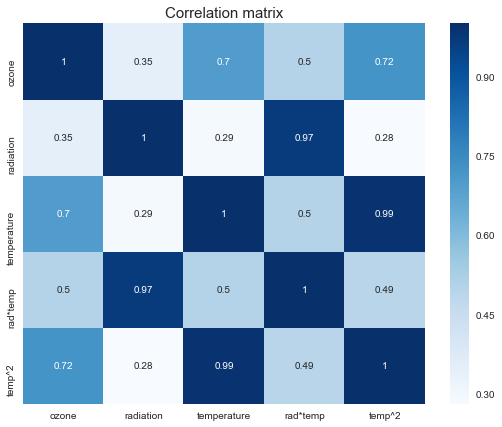

In [69]:
# Correlation Matrix of the 3rd case's dataset

corr2 = data2[['ozone']+ I3].corr()
plt.figure(figsize=(9,7))
plt.title('Correlation matrix', size=15)
sns.heatmap(corr2, annot=True, cmap='Blues')

The correlation matrix shows that the features $temperature$, $radiation \times temperature$, and $temperature^2$ are well correlated with targets, which may be the factor that made this combination better than the four other ones.